# Лабораторная работа №1
### Конечномерная оптимизация, градиентные методы

## Постановка задачи

1) Реализовать модификацию Gradient Descent. Выбрать 2 функции из Scikit-Learn или книги.

2) Реализовать визуализацию спуска. Реализовать SGD(Stochastic GD) + SGF with LR schedule.

3) Реализовать по одному моментному и адаптивному методу

## Gradient Descent + Learning Rate Schedule

In [238]:
''' Imports '''
from typing import Tuple, Mapping, Callable, Dict
from IPython import display

import numpy as np
import random

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [239]:
def GradientDescent(
    f: Callable, df: Callable, 
    x0: np.ndarray,
    lr: float = 0.001,
    T: int = 100,
    is_enable_lrs: bool = False,
    lre: int = 7, g: float = 0.1
    ) -> dict:
    '''
    Нативная реализация градиентного спуска
    
    Args:
        f (Callable): Функционал для оптимизации
        df (Callable): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
        is_enable_lrs(bool): Активировать модификацию Learning Rate Schedule
        lre (int): Через сколько эпох мы уменьшим lr. Default = 7. [Aктивно только при is_enable_lrs == True]
        g (float): Коэфициент уменьшения lr [0,1). Default = 0.1.  [Aктивно только при is_enable_lrs == True]
    
    Returns:
        Dict - Данные о работе оптимизации функции:
            'x_optimal'      - [np.ndarray] оптимальное расположение точки.
            'optimum_value'  - [np.float32] значение минимизируемой функции в 
                                точке найденного оптимума.
    '''
    
    assert(T >= 1)
    assert(callable(f))
    assert(callable(df))
    assert(lr > 0)
    assert(lre > 0)
    assert(g < 1 and g >= 0)
    
    x_old = x0.copy()
    for i in range(T):
        
        if i % lre == 0 and is_enable_lrs:
            lr *= g
            
        grad = df(x_old)
        x_new = x_old - lr * grad
        x_old = x_new.copy()
        
    return {'x_optimal': x_new, 'optimum_value': f(x_new)}

## Функция Химмельблау

$$ f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 $$

In [240]:
def Himmelblau(x: np.ndarray) -> np.float64:
    '''
    Функция Химмельблау
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.float64: Результат функции
    '''
    
    if np.size(x) < 2:
        raise ValueError(f'Input argument for Himmelblau function: X input size is {np.size(x)}, expected: 2 or greater.')
        
    return np.square(np.square(x[0]) + x[1] - 11) + np.square(x[0] + np.square(x[1]) - 7);


def HimmelblauGradient(x: np.ndarray) -> np.ndarray:
    '''
    Градиент функции Himmelblau.
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.ndarray: Градиент функции Himmelblau в точке X.
    '''
    return np.array([
            (4 * x[0] * (np.square(x[0]) + x[1] - 11) + 2 * (x[0] + np.square(x[1]) - 7)), 
            (2 * (np.square(x[0]) + x[1] - 11) + 4 * x[1] * (x[0] + np.square(x[1]) - 7))
        ]);

In [241]:
def print_title(*args, indent_size: int = 30, sym:str = '='):
    '''
    Форматированный вывод заголовков через print.
    
    Args:
        indent_size(int)[Optional]: Размер отступов заголовка слева и справа
        sym(str)[Optional]: Символ для отступа заголовка
    '''
    print(sym * indent_size, *args, sym * indent_size)

In [242]:
points = [
    {"x": 3.0,      "y": 2.0,      "z": 0.0},
    {"x":-2.805118, "y": 3.131312, "z": 0.0},
    {"x":-3.779310, "y":-3.283186, "z": 0.0}
]

print_title("Himmelblau Function Validation")

for point in points:
    x, y, z = point['x'], point['y'], point['z']
    print(f'\nFor point:  [{x}, {y}] and analyticical solution Z = {z}')
    print(f'\tHimmelblau({x}, {y}) = {Himmelblau([x, y])}')
    print(f'\tHimmelblau Gradient({x}, {y}) = {HimmelblauGradient([x, y])}')

============================== Himmelblau Function Validation ==============================

For point:  [3.0, 2.0] and analyticical solution Z = 0.0
	Himmelblau(3.0, 2.0) = 0.0
	Himmelblau Gradient(3.0, 2.0) = [0. 0.]

For point:  [-2.805118, 3.131312] and analyticical solution Z = 0.0
	Himmelblau(-2.805118, 3.131312) = 1.0989296656869089e-11
	Himmelblau Gradient(-2.805118, 3.131312) = [ 4.97133560e-06 -4.15751018e-05]

For point:  [-3.77931, -3.283186] and analyticical solution Z = 0.0
	Himmelblau(-3.77931, -3.283186) = 3.797861082863832e-12
	Himmelblau Gradient(-3.77931, -3.283186) = [ 2.97052500e-05 -7.92677776e-06]


In [243]:
GradientDescent(Himmelblau, HimmelblauGradient, [5, 5])

{'x_optimal': array([2.98222825, 2.04137631]),
 'optimum_value': 0.026550944921419198}

In [244]:
def plot_colormesh(
    f: Callable, 
    ranges: Tuple, 
    step: Tuple[float, float],
    figsize: Tuple[int, int] = (15, 10),
    title: str = "Title",
    colormap: str = 'PiYG',
    nbins:int = 100,
    ):

    dx, dy = step[0], step[1]

    y, x = np.mgrid[
                slice(ranges[0][0], ranges[0][1] + dy, dy),
                slice(ranges[1][0], ranges[1][1] + dx, dx)
            ]
    
    z = f([x, y])[:-1, :-1]

    levels = MaxNLocator(nbins=nbins).tick_values(z.min(), z.max())

    cmap = plt.colormaps[colormap]
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x[:-1, :-1] + dx/2.,
                      y[:-1, :-1] + dy/2., z, levels=levels,
                      cmap=cmap)
    fig.colorbar(cf, ax=ax)
    ax.set_title(title)

    fig.tight_layout()
    return fig, ax

Gradient Descent result:
	Found optimum coodrinates: [-3.77931025 -3.28318599]
	Found optimum value      : 4.5753932502818685e-28


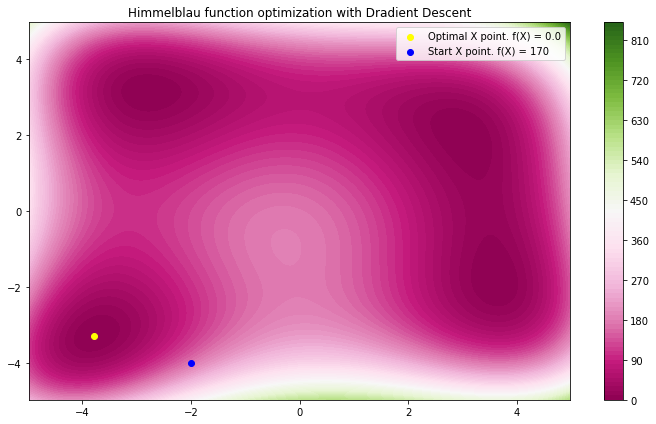

In [245]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Dradient Descent"
)

start_point = np.array([-2, -4])

gradient_descent_result = GradientDescent(Himmelblau, HimmelblauGradient, start_point, T=1000)

print("Gradient Descent result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']
ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')
ax.legend()
plt.show()

Gradient Descent + LRS result:
	Found optimum coodrinates: [-3.77931019 -3.2831859 ]
	Found optimum value      : 4.3585862753524813e-13


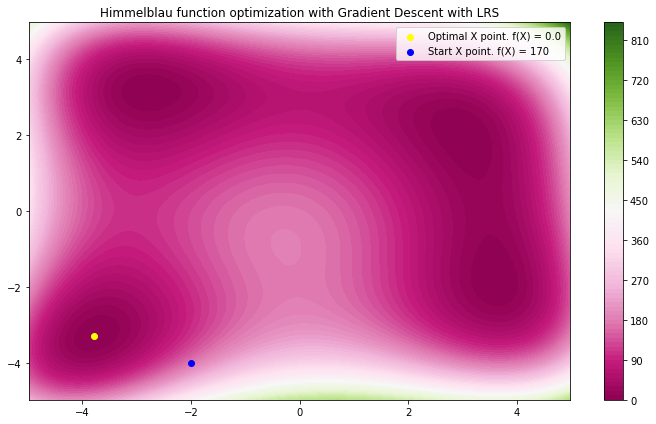

In [246]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Gradient Descent with LRS"
)

start_point = np.array([-2, -4])

gradient_descent_result = GradientDescent(Himmelblau, HimmelblauGradient, start_point, 
                                          T=1000, lre = 100, g=0.7, is_enable_lrs=True)

print("Gradient Descent + LRS result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']

ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', 
           label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')

ax.legend()
plt.show()

## Функция Комрика

$$ f(x, y) = sin(x + y)+(x - y)^2 - 1.5x + 2.5y +1 $$

In [247]:
def McCormick(x: np.ndarray) -> np.float64:
    '''
    Функция Cormick
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элементов в массиве.
        
    Returns:
        np.float64: Результат функции
    '''
    return np.sin(x[0] + x[1]) + np.square(x[0] - x[1]) - 1.5 * x[0] + 2.5 * x[1] + 1


def McCormickGradient(x: np.ndarray) -> np.ndarray:
    '''
    Градиент функции Cormick.
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элементов в массиве.
        
    Returns:
        np.ndarray: Градиент функции Cormick в точке X.
    '''
    return np.array([
        np.cos(x[0] + x[1]) + 2 * (x[0] - x[1]) - 1.5, 
        np.cos(x[0] + x[1]) - 2 * (x[0] - x[1]) + 2.5
    ]);

In [248]:
GradientDescent(McCormick, McCormickGradient, [0, 0])

{'x_optimal': array([ 0.01656293, -0.3136545 ]),
 'optimum_value': 0.007322468346568467}

Gradient Descent result:
	Found optimum coodrinates: [-0.45210452 -1.45213451]
	Found optimum value      : -1.897040669863629


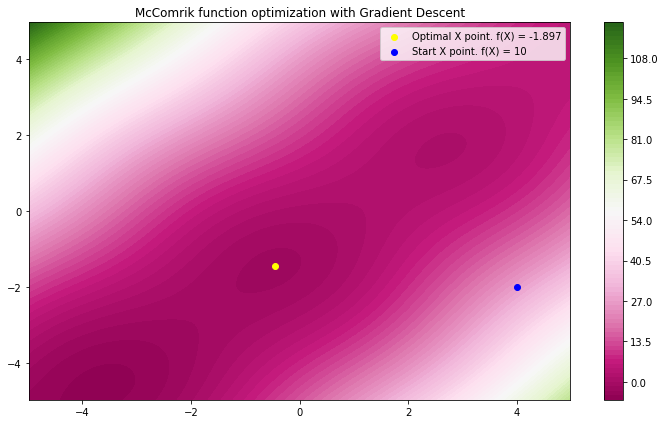

In [249]:
fig, ax = plot_colormesh(
    McCormick, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="McComrik function optimization with Gradient Descent"
)

start_point = np.array([4, -2])

gradient_descent_result = GradientDescent(McCormick, McCormickGradient, start_point, T=3000)

print("Gradient Descent result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']

ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', 
           label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')

ax.legend()
plt.show()

Gradient Descent + LRS result:
	Found optimum coodrinates: [ 0.22200998 -0.7805881 ]
	Found optimum value      : -0.8092632810060583


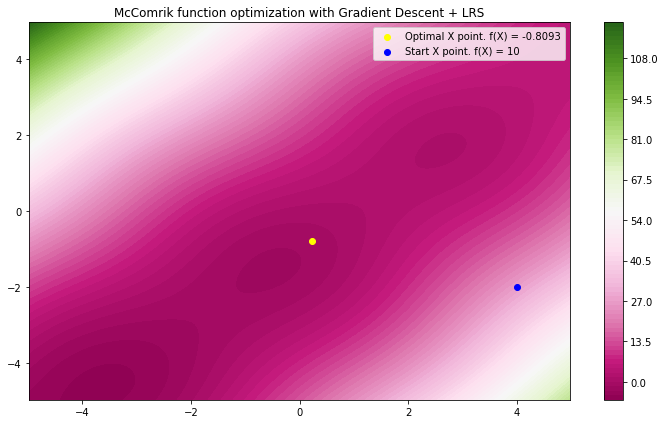

In [236]:
fig, ax = plot_colormesh(
    McCormick, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="McComrik function optimization with Gradient Descent + LRS"
)

start_point = np.array([4, -2])

gradient_descent_result = GradientDescent(McCormick, McCormickGradient, 
                                          start_point, T=10000, lre=100, g=0.95, is_enable_lrs=True)

print("Gradient Descent + LRS result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']

ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', 
           label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')

ax.legend()
plt.show()

## Моментный метод (+ Нестерова)

In [251]:
def NesterovAGD(f: Callable, df: Callable, 
                x0: np.ndarray, 
                lr: float = 0.01, T: int = 100, 
                lre: int = 7, g: float = 0.1, 
                gamma: float = 0.9) -> dict:
    '''
    Нативная реализация оптимизитора Нестерова
    
    Args:
        f (Callable): Функционал для оптимизации
        df (Callable): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
        is_enable_lrs(bool): Активировать модификацию Learning Rate Schedule
        lre (int): Через сколько эпох мы уменьшим lr. Default = 7.
        g (float): Коэфициент уменьшения lr [0,1). Default = 0.1.
        gamma(float): Коэфициент сохранения момента памяти для следующего шага. Default = 0.9.
        
    Returns:
        Dict - Данные о работе оптимизации функции:
            'x_optimal'      - [np.ndarray] оптимальное расположение точки.
            'optimum_value'  - [np.float32] значение минимизируемой функции в 
                                точке найденного оптимума.
    '''
    assert(callable(f))
    assert(callable(df))
    assert(lr > 0.0)
    assert(T >= 1)
    assert(lre >= 1)
    assert(g >= 0.0 and g < 1.0)
    assert(gamma > 0.0 and gamma < 1.0)
    
    x_old = x0.copy()
    v_t = np.zeros(df(x0).shape)
    
    for i in range(T):
        
        if i % lre == 0:
            lr *= g
        
        v_t = gamma * v_t - lr * df(x_old + gamma * v_t)
        x_new = x_old + v_t
        x_old = x_new.copy()
        
    return {'x_optimal': x_new.copy(), 'optimum_value': f(x_new)}

In [252]:
NesterovAGD(Himmelblau, HimmelblauGradient, [-2, -4] , lr=0.01, lre=20, g=0.5, gamma=0.9, T=1000)

{'x_optimal': array([-3.77931022, -3.28318594]),
 'optimum_value': 1.1890309002532147e-13}

Nesterov Dradient Descent result:
	Found optimum coodrinates: [-3.77931022 -3.28318594]
	Found optimum value      : 1.1890309002532147e-13


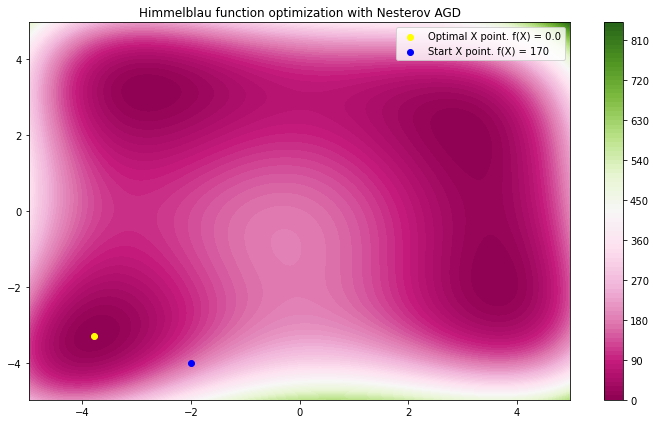

In [253]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Nesterov AGD"
)

start_point = np.array([-2, -4])

gradient_descent_result = NesterovAGD(Himmelblau, HimmelblauGradient, start_point, lr=0.01, lre=20, g=0.5, T=1000)

print("Nesterov Dradient Descent result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']

ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')

ax.legend()
plt.show()

## Адаптивный метод (ADAM)

In [254]:
def Adam(
    f: Callable, df: Callable, 
    x0: np.ndarray, lr: float = 0.01,
    T: int = 100, lre: int = 7, 
    g: float = 0.1, 
    beta1: float = 0.9, 
    beta2: float = 0.9) -> dict:
    '''
    Нативная реализация адаптивного метода оптимизации Adam
    
    Args:
        f (Callable): Функционал для оптимизации
        df (Callable): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка
        lr (float): Скорость обучения. Default=0.01.
        T (int): Количество итераций.
        lre (int): Через сколько эпох мы уменьшим lr. Default = 7.
        g (float): Коэфициент уменьшения lr [0,1). Default = 0.1
        mom (float): Коэфициент сохранения момента Default = 0.9
        mom_flat (float): Коэфициент сохранения момента сглаживания Default = 0.9
    
    Returns:
        Dict - Данные о работе оптимизации функции:
            'x_optimal'      - [np.ndarray] оптимальное расположение точки.
            'optimum_value'  - [np.float32] значение минимизируемой функции в 
                                точке найденного оптимума.
    
    '''
    
    assert(callable(f))
    assert(callable(df))
    assert(lr > 0.0)
    assert(T >= 1)
    assert(lre >= 1)
    assert(g >= 0.0 and g < 1.0)
    assert(beta1 > 0.0 and beta1 < 1.0)
    assert(beta2 > 0.0 and beta2 < 1.0)
    
    x_old = x0.copy()
    
    func_output_shape = df(x_old).shape
    EPS = 0.0000001
    
    m_t = np.zeros(func_output_shape)
    v_t = np.zeros_like(m_t)
    
    Grad_SQRT = np.zeros(func_output_shape)
    
    for i in range(T):
        
        if i % lre == 0:
            lr *= g
        
        g_t = df(x_old)
        m_t = beta1 * m_t + (1 - beta1) * g_t
        v_t = beta2 * v_t + (1 - beta2) * g_t ** 2
        
        m_t_corr = m_t / (1 - beta1 ** (i + 1))
        v_t_corr = v_t / (1 - beta2 ** (i + 1))
        
        x_new = x_old - g * (m_t_corr / (np.sqrt(v_t) + EPS))
        x_old = x_new.copy()
        
    return {'x_optimal': x_new, 'optimum_value': f(x_new)}

In [255]:
Adam(Himmelblau,HimmelblauGradient,[-2, -4], lr=0.1, lre=50, g=0.999, T=10000)

{'x_optimal': array([-2.83700524,  3.14606659]),
 'optimum_value': 0.04158268077928221}

Adam optimizer result:
	Found optimum coodrinates: [-2.84337663  3.14893738]
	Found optimum value      : 0.05987489761757903


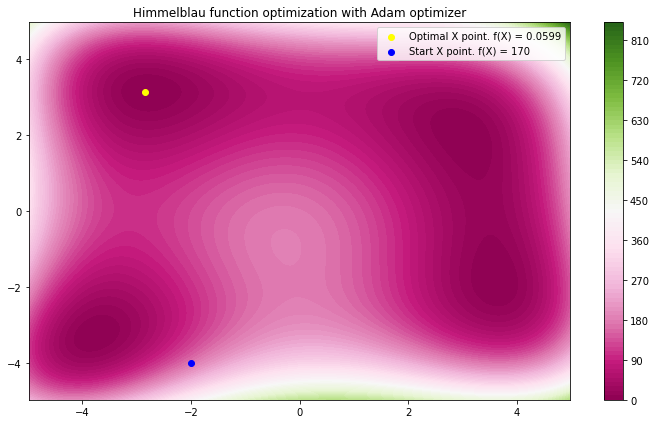

In [256]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Adam optimizer"
)

start_point = np.array([-2, -4])

gradient_descent_result = Adam(Himmelblau, HimmelblauGradient, start_point, lr=0.1, lre=50, g=0.99)

print("Adam optimizer result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']
ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')
ax.legend()
plt.show()